In [16]:
%pip install pandas seaborn matplotlib 

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached fonttools-4.60.1-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm64.whl (4.7 MB)
     |████████████████████████████████| 249 kB 33 kB/s eta 0:00:01
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     |████████████████████████████████| 64 kB 308 kB/s eta 0:00:01
You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_dir = current_dir.parent / "drafts"

files = list(draft_dir.glob("draft_*.csv"))

df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    df = pd.concat([df, curr_df])

df = df.sort_values(by=["SEASON", "OVERALL_PICK"]) 
df.to_csv(draft_dir / "drafts.csv", index=False)

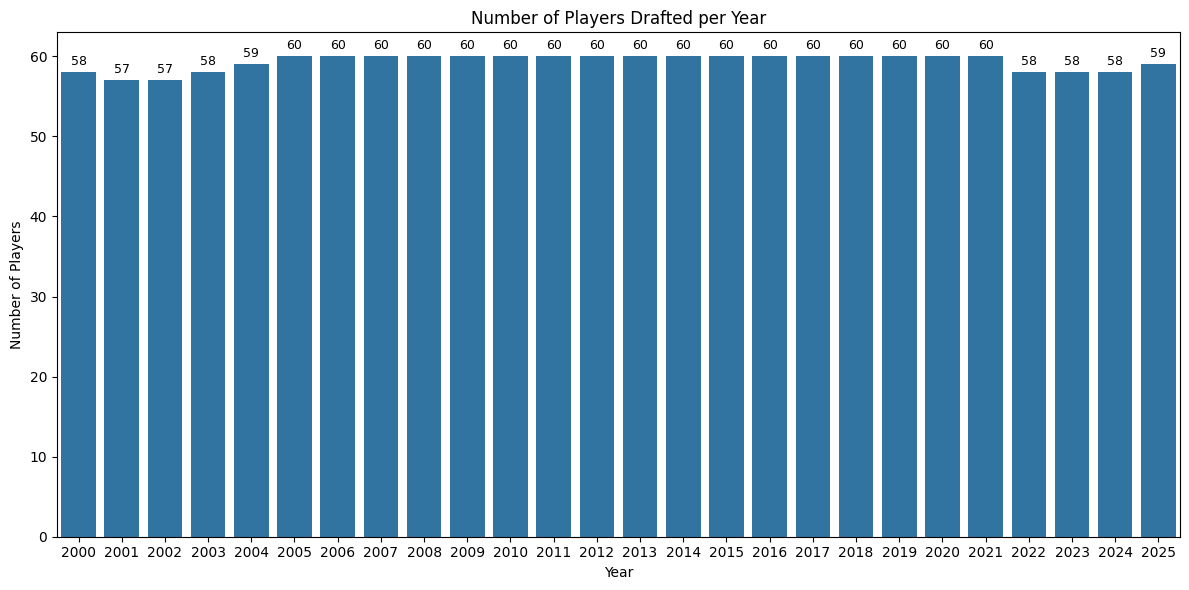

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()